# K-Means Algorithm

In this Jupyter Notebook we will focus on K-Means algorithm. K-means is an entry level clusterization algorithm. Clusterization is subdomain of Machine Learning which is all about finding hidden patterns in datasets. K-means is so called unsupervised learning method. In contrast to traditional methods in unsupervised methods we have data points, but we don't have labels. Based on distances between data algorithm finds k groups of points in a given dataset.
 
K menas finds k (iteger e.g 2 or 16 etc.) groups of data in a given dataset and it make it ONLY based on their place in a given space (e.g $R^2$. or $R^3$). Algorithm is quite simple but suprasingly effective. We inicialize  k random points (called centroids) in a given space. Then we find points closest to each centroid and from that points we form a group. Mean value for each group is new centroid. We repeat algorithm as long as our centroids "move" more then some threshold value $\Delta$

Number k depends on a sytuation and problem. For example we want to reduce number of colors in the image in order to compress its size. We find 256 the most important colors and we replace color of each pixel with one of those 256 colors (the closest one to the original pixel value).

<img src="images/k-means.gif"  height="60%" width="60%">

## K-means steps

1. Select $k$ random points as initial centroids
2. Count distances between points in dataset and centroids
3. Assign each point to closest centroid
4. Find mean or each group of points and set it as new centroids
5. Check if centroids moved more then some $\Delta$. If no - repeat steps 2-5, if yes - algorithm covered, we found $k$ centroids for given data

## Imports

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import random
import cv2

## Set random seed

In [2]:
random.seed(7)
np.random.seed(7)

# Select $k$ random points as initial centroids

As initial centroids we take k random, unique points from dataset. We take unique points to avoid a situation where there is a centroid without any points.

In [3]:
def get_initial_centroids(X, k):
    """
    Function picks k random data points from dataset X, recurring points are removed and replaced but new points
    so a result we have array of k unique points. Founded points can be used as intial centroids for k means algorithm
    Args:
        X (numpy.ndarray) : dataset points array, size N:D
        k (int): number of centroids

    Returns:
        (numpy.ndarray): array of k unique initial centroids, size K:D

    """
    number_of_samples = X.shape[0]
    sample_points_ids = random.sample(range(0, number_of_samples), k)

    centroids = [tuple(X[id]) for id in sample_points_ids]
    unique_centroids = list(set(centroids))

    number_of_unique_centroids = len(unique_centroids)

    while number_of_unique_centroids < k:
        new_sample_points_ids = random.sample(range(0, number_of_samples), k - number_of_unique_centroids)
        new_centroids = [tuple(X[id]) for id in new_sample_points_ids]
        unique_centroids = list(set(unique_centroids + new_centroids))

        number_of_unique_centroids = len(unique_centroids)

    return np.array(unique_centroids)

## Example usage

In [4]:
X = np.array([[1,1,1], [2,2,2], [3,3,3], [4,4,4]])

k = 2

print(f"Dataset:\n {X}")
print(f"Dataset shape {X.shape}")
print(f"Founded k={k} initial centroids for a given dataset {get_initial_centroids(X, k)}")

Dataset:
 [[1 1 1]
 [2 2 2]
 [3 3 3]
 [4 4 4]]
Dataset shape (4, 3)
Founded k=2 initial centroids for a given dataset [[3 3 3]
 [1 1 1]]


# Count distances between points in dataset and centroids

In order to form a group (based on whitch we will find new centroid) we need to find centroid closest each data point in dataset. Depending on Your problem You can use diffrent methods of mesuring the distance between centroids and data points. 

For our problem euclidean distance is fine. To compute it in an effective way we will make use of matrix methods from numpy package, which are much more efficient than loops. 

$A = \begin{bmatrix}
       a & b \\
       c & d \\
       e & f \\
     \end{bmatrix} \space B = \begin{bmatrix}
       g & h \\
     \end{bmatrix}$    
     
$DistanceMatrix = \begin{bmatrix}
                   \sqrt{(a-g)^2 + (b-h)^2} \\
                   \sqrt{(c-g)^2 + (d-h)^2} \\
                   \sqrt{(e-g)^2 + (f-h)^2} \\
                 \end{bmatrix} = \sqrt{\begin{bmatrix}
                                  a^2 + b^2 \\
                                  c^2 + d^2 \\
                                  e^2 + f^2 \\
                                  \end{bmatrix} + \begin{bmatrix}
                                  g^2 + h^2 \\
                                  g^2 + h^2 \\
                                  g^2 + h^2 \\
                                  \end{bmatrix} - 2\begin{bmatrix}
                                  a*g + b*h \\
                                  c*g + d*h \\
                                  e*g + f*h \\
                                  \end{bmatrix}} = \sqrt{(A*A)_{column \space sum} + (B*B)_{column \space sum} - 2*AB^T}$   
                                  
                                  
<br>

For example we have 3 points in dataset matrix $A = \begin{bmatrix}1 & 2 \\ 2 & 3 \\ 3 & 4 \end{bmatrix}$ and 1 point in centroid matrix $B = \begin{bmatrix}0 & 1 \end{bmatrix}$ 

Euklidean distance between points in $A$ and $B$ = $\sqrt{\begin{bmatrix}(1-0)^2 + (2-1)^2 \\(2-0)^2 + (3-1)^2 \\ (3-0)^2 + (4-1)^2 \\ \end{bmatrix}} = \begin{bmatrix}\sqrt{2} \\ \sqrt{8} \\ \sqrt{18} \\ \end{bmatrix} $ 


*$\sqrt{\begin{bmatrix}1 & 2 \\ 2 & 3 \\ 3 & 4 \end{bmatrix}}$ this is not a 100 percent correct mathematical notation but it is intended to give you some idea of what is going on

In [5]:
def get_euclidean_distance(A_matrix, B_matrix):
    """
    Function computes euclidean distance between matrix A and B.
    E. g. C[2,15] is distance between point 2 from A (A[2]) matrix and point 15 from matrix B (B[15])
    Args:
        A_matrix (numpy.ndarray): Matrix size N1:D
        B_matrix (numpy.ndarray): Matrix size N2:D

    Returns:
        numpy.ndarray: Matrix size N1:N2
    """

    A_square = np.reshape(np.sum(A_matrix * A_matrix, axis=1), (A_matrix.shape[0], 1))
    B_square = np.reshape(np.sum(B_matrix * B_matrix, axis=1), (B_matrix.shape[0]), 1)
    AB = A_matrix @ B_matrix.T

    C = -2 * AB + B_square + A_square

    return np.sqrt(C)

## Example usage

In [6]:
A = np.array([[1,2], [2, 3], [3,4]])
B = np.array([[0,1]])

print(f"A:\n{A}")
print(f"B:\n{B}")
print(f"Distance matrix:\n{get_euclidean_distance(A,B)}")

A:
[[1 2]
 [2 3]
 [3 4]]
B:
[[0 1]]
Distance matrix:
[[1.41421356]
 [2.82842712]
 [4.24264069]]


# Find new clusters

For each centroid assign closest points from dataset

In [7]:
def get_clusters(X, centroids, distance_mesuring_method):
    """
    Function finds k centroids and assigns each of the N points of array X to one centroid
    Args:
        X (numpy.ndarray): array of sample points, size N:D
        centroids (numpy.ndarray): array of centroids, size K:D
        distance_mesuring_method (function): function taking 2 Matrices A (N1:D) and B (N2:D) and returning distance
        between all points from matrix A and all points from matrix B, size N1:N2

    Returns:
        dict {cluster_number: list_of_points_in_cluster}
    """

    k = centroids.shape[0]

    clusters = {}

    distance_matrix = distance_mesuring_method(X, centroids)

    closest_cluster_ids = np.argmin(distance_matrix, axis=1)

    for i in range(k):
        clusters[i] = []

    for i, cluster_id in enumerate(closest_cluster_ids):
        clusters[cluster_id].append(X[i])

    return clusters


## Example usage

In [8]:
X = np.array([[1,2], [2, 3], [3,4]])
centroids = np.array([[0,0], [5,5]])

print(f"Points {X[0]} and X[1] are closer to centroids[0] so they will be in same claster")
print(f"Point {X[2]} is closer to {centroids[1]} so they will be in 2nd claster")

print(f"Clusters: {get_clusters(X, centroids, get_euclidean_distance)}")

Points [1 2] and X[1] are closer to centroids[0] so they will be in same claster
Point [3 4] is closer to [5 5] so they will be in 2nd claster
Clusters: {0: [array([1, 2]), array([2, 3])], 1: [array([3, 4])]}


# Check if clusters changed

To stop algorithm we need to chceck if centroids are still "moving". To do that we count distance between old centroids and new centroids (corresponding centroids lie on the main diagonal of distance matrix) and if all of distances are smaller then $\Delta$ paramter we know that algorithm had covered and we reached final centroids

In [9]:
def has_centroids_covered(previous_centroids, new_centroids, distance_mesuring_method, movement_threshold_delta):
    """
    Function checks if any of centroids moved more then MOVEMENT_THRESHOLD_DELTA if not we assume the centroids were founded
    Args:
        previous_centroids (numpy.ndarray): array of k old centroids, size K:D
        new_centroids (numpy.ndarray): array of k new centroids, size K:D
        distance_mesuring_method (function): function taking 2 Matrices A (N1:D) and B (N2:D) and returning distance
        movement_threshold_delta (float): threshold value, if centroids move less we assume that algorithm covered


    Returns: boolean True if centroids coverd False if not

    """
    distances_between_old_and_new_centroids = distance_mesuring_method(previous_centroids, new_centroids)
    centroids_covered = np.max(distances_between_old_and_new_centroids.diagonal()) <= movement_threshold_delta

    return centroids_covered

# Combine all steps and perform k-means algorithm

Now we can combine all steps and find k centroids for any given dataset

In [10]:
def perform_k_means_algorithm(X, k, distance_mesuring_method, movement_threshold_delta=0):
    """
    Function performs k-means algorithm on a given dataset, finds and returns k centroids
    Args:
        X (numpy.ndarray) : dataset points array, size N:D
        distance_mesuring_method (function): function taking 2 Matrices A (N1:D) and B (N2:D) and returning distance
        between all points from matrix A and all points from matrix B, size N1:N2.
        k (int): number of centroids
        movement_threshold_delta (float): threshold value, if centroids move less we assume that algorithm covered

    Returns:
        (numpy.ndarray): array of k centroids, size K:D
    """

    new_centroids = get_initial_centroids(X=X, k=k)

    centroids_covered = False

    while not centroids_covered:
        previous_centroids = new_centroids
        clusters = get_clusters(X, previous_centroids, distance_mesuring_method)

        new_centroids = np.array([np.mean(clusters[key], axis=0, dtype=X.dtype) for key in sorted(clusters.keys())])

        centroids_covered = has_centroids_covered(previous_centroids, new_centroids, distance_mesuring_method, movement_threshold_delta)

    return new_centroids


# Finding centroids for 2D dataset

As an example of how our algorithm performs, we will find k centroids in a group of 3000 points in space $R^2$

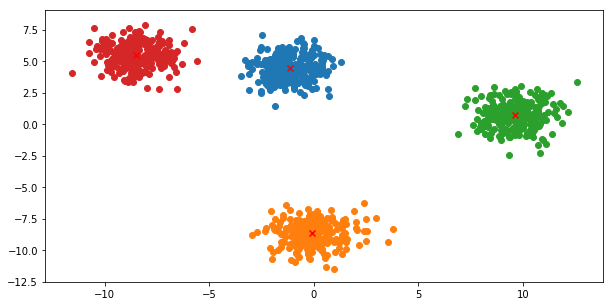

In [11]:
k = 4

X, _ = make_blobs(n_samples=1000, n_features=2, centers=k)

centroids = perform_k_means_algorithm(X, k, movement_threshold_delta=1/10, distance_mesuring_method=get_euclidean_distance)

clusters = get_clusters(X, centroids, get_euclidean_distance)

plt.rcParams['figure.figsize'] = [10, 5]
for centroid, points in clusters.items():
    points = np.array(points)
    centroid = np.mean(points, axis=0)


    plt.scatter(points[:, 0], points[:, 1], marker='o')
    plt.grid()
    plt.scatter(centroid[0], centroid[1], marker='x', color="red")

plt.show()

# Reduce number of colors in an image

One of popular applications of clasterization algorithms is color reduction. Algorithm finds k "most important" values (colors when we talk about images) and then replace each datapoint (pixel in our example) value with one of this k values (the closest one). Thanks to that it is possibile to significently reduce size of files. To measure how good our compression performs we can count diffrence between original source (image) and reconstrucion

In [12]:
def get_reduced_colors_image(image, number_of_colors):
    """
    Function returns given image with reduced number of colors
    Args:
        image (numpy.ndarray): original opencv image, function finds its reduced colors form
        number_of_colors (integer): number of colors in reduced image

    Returns:
        (numpy.ndarray): image with reduced number of colors
    """

    h, w, d = image.shape

    X = np.reshape(image, (h * w, d))
    X = np.array(X, dtype=np.int32)

    centroids = perform_k_means_algorithm(X, k=number_of_colors, distance_mesuring_method=get_euclidean_distance)
    distance_matrix = get_euclidean_distance(X, centroids)
    closest_cluster_ids = np.argmin(distance_matrix, axis=1)

    X_reconstructed = centroids[closest_cluster_ids]
    X_reconstructed = np.array(X_reconstructed, dtype=np.uint8)
    reduced_image = np.reshape(X_reconstructed, (h, w, d))

    return reduced_image

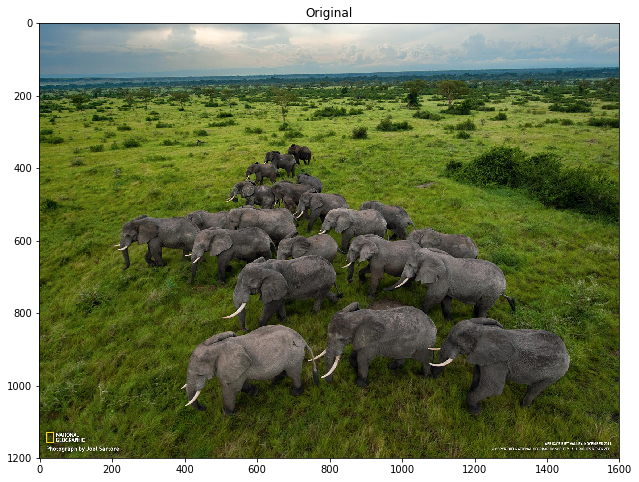

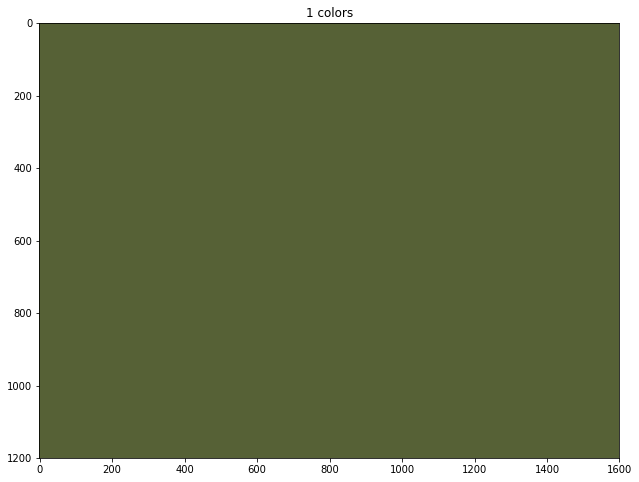

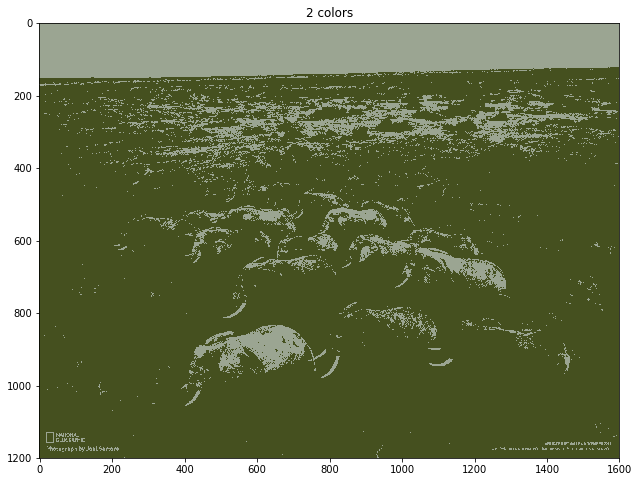

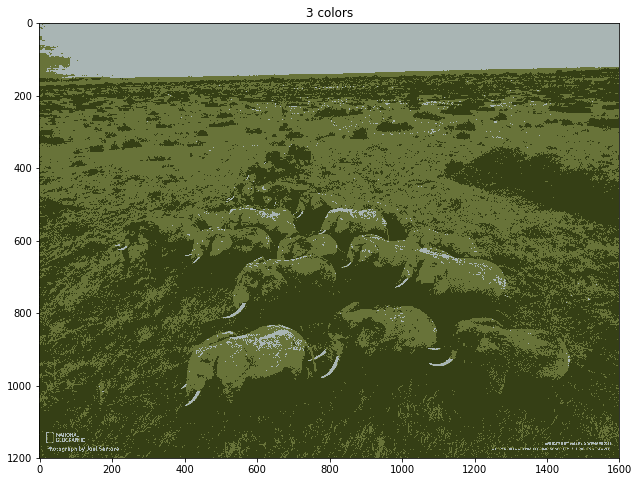

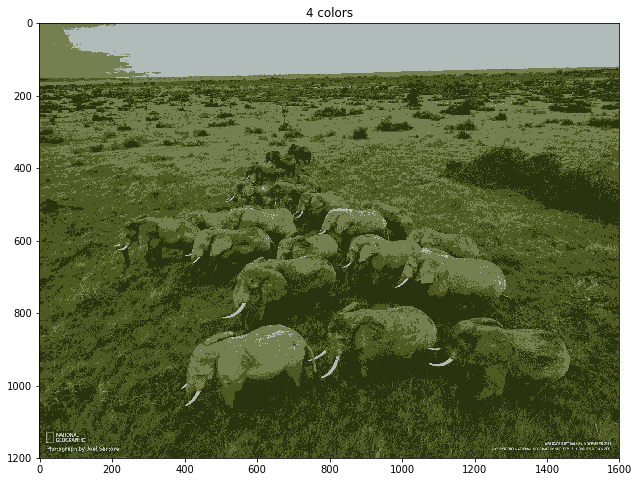

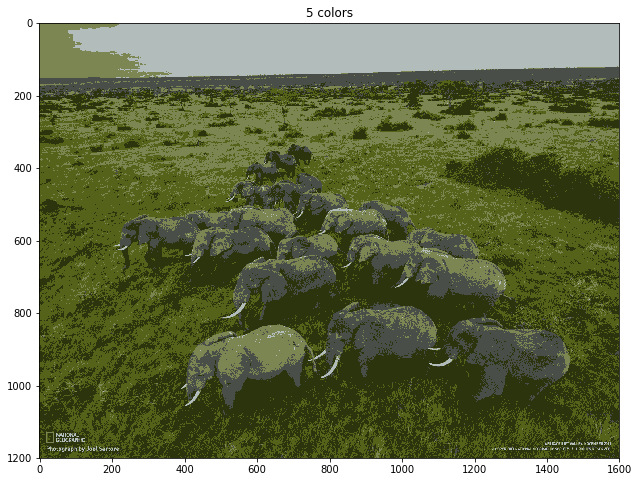

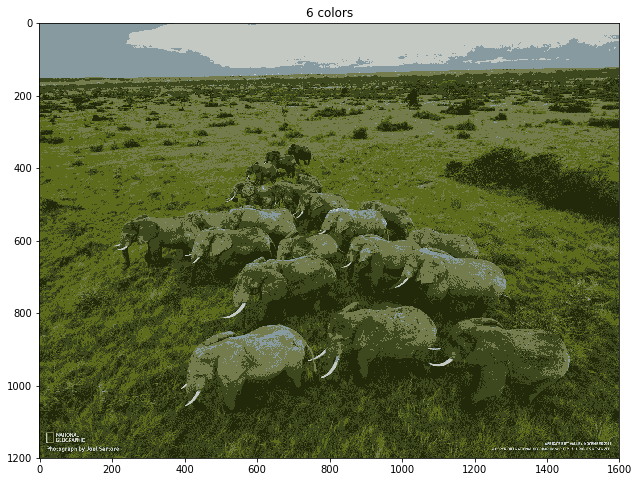

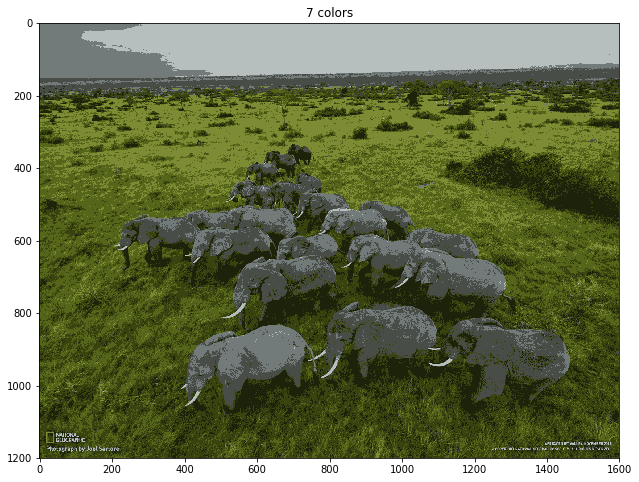

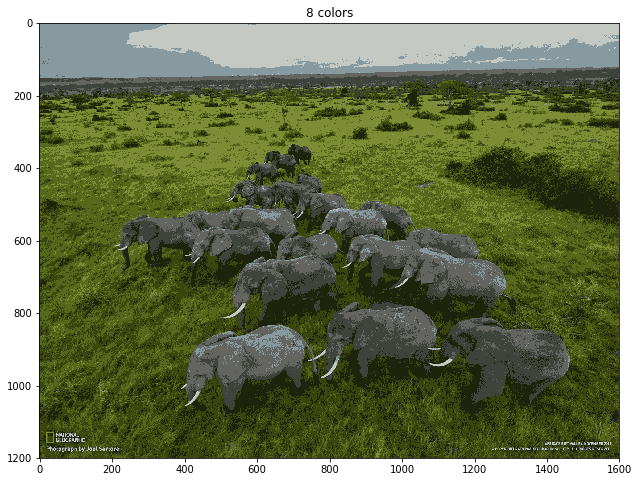

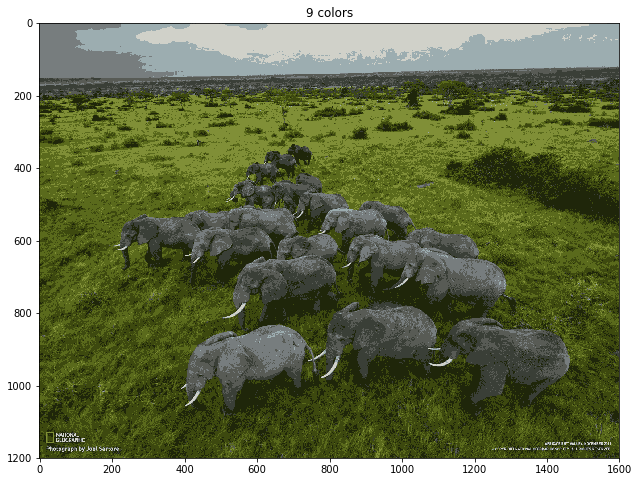

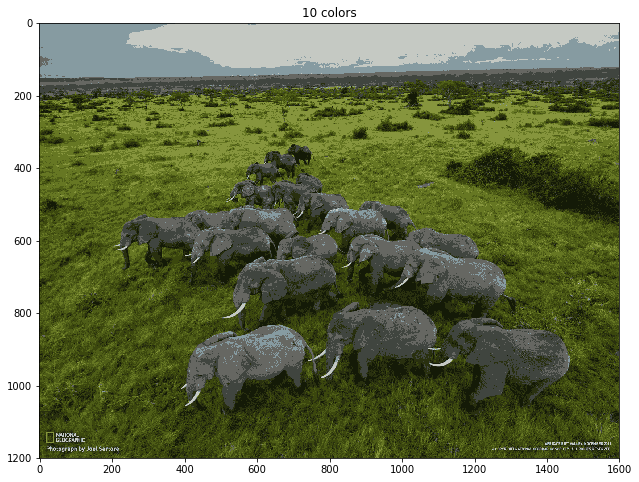

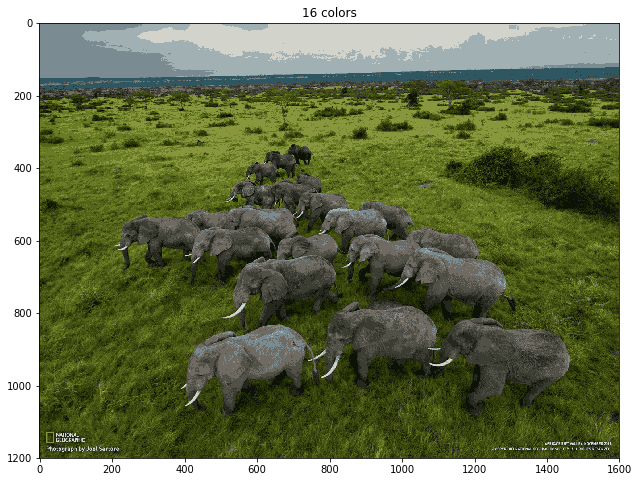

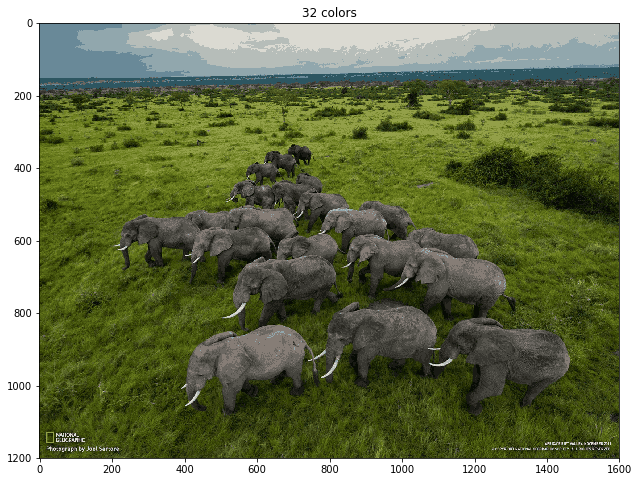

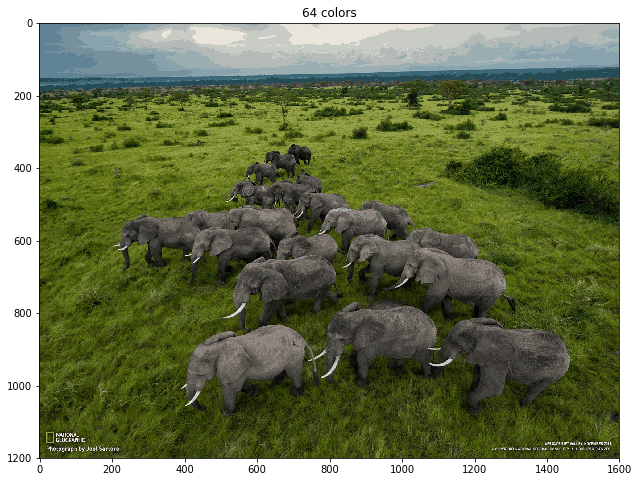

In [13]:
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 32, 64]

reconstrutons = []


img = cv2.imread("image.jpg")
plt.rcParams['figure.figsize'] = [15, 8]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.show()

for k in k_values:
    reduced_colors_image = get_reduced_colors_image(img, k)
    plt.title(f"{k} colors")
    plt.imshow(cv2.cvtColor(reduced_colors_image, cv2.COLOR_BGR2RGB))
    plt.show()
    reconstrutons.append(reduced_colors_image)


# Count distortion

To measure how good algorithm perfoms we can count distortion between original source $x$ and reconstruction $\hat{x}$ $D = \sum_{i=1}^n (x-\hat{x})^2$. Smaller distortion means "reconstruction" is closer to orignial source.

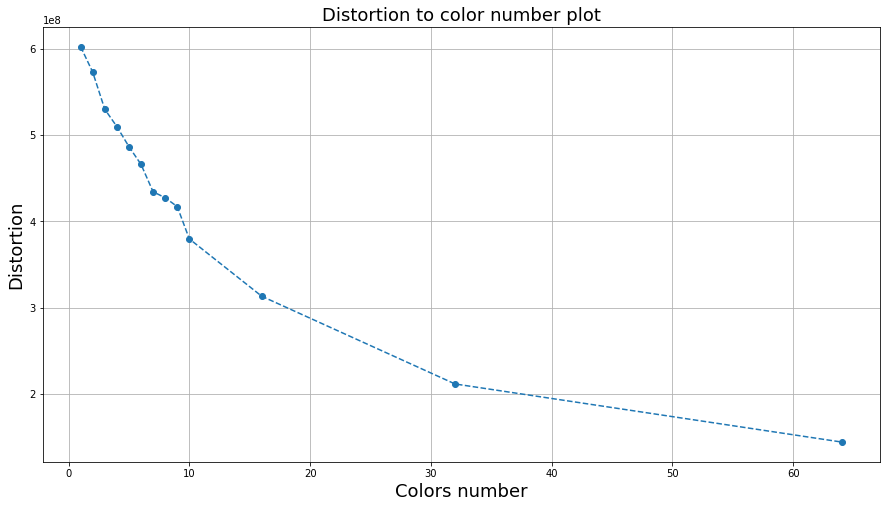

In [14]:
distortions=[]

for i, k in enumerate(k_values):
    distortion = np.sum(np.square(img-reconstrutons[i]))
    
    distortions.append(distortion)
    
plt.grid()
plt.title("Distortion to color number plot", fontsize=18)
plt.xlabel('Colors number', fontsize=18)
plt.ylabel('Distortion', fontsize=18)
plt.plot(k_values, distortions, linestyle='--', marker='o')
plt.show()

# Summary


We managed to create an effective clustering algorithm. We showed how it works on the example of color reduction. The same algortym can be effectively used for many problems from different areas by changing only the input X, the number of classes k and possibly the method of measuring distances.

# Resources

- https://www.nationalgeographic.com/animals/photos/elephants/ elephant photo 

- https://thumbs.gfycat.com/PaltryFarflungArkshell-small.gif k means gif